In [393]:
# https://youtu.be/XyX5HNuv-xE
"""
Multiclass semantic segmentation using U-Net
"""

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import albumentations as A

#connect your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [401]:
# IMAGE_PATH = '/content/drive/MyDrive/annotation_data/unet_training_data/images_128_128/*'
# IMAGE_PATH = '/content/drive/MyDrive/annotation_data/unet_training_data/images_256_256/*'
IMAGE_PATH = '/content/drive/MyDrive/annotation_data/unet_training_data/images_256_256_corrected_orientations/*'

# MASK_PATH = '/content/drive/MyDrive/annotation_data/unet_training_data/masks_128_128/*'
MASK_PATH = '/content/drive/MyDrive/annotation_data/unet_training_data/masks_256_256/*'
# MASK_PATH = '/content/drive/MyDrive/annotation_data/unet_training_data/masks_256_256_with_damage_classes/*' #training model to seperate damaged wings
# MASK_PATH = '/content/drive/MyDrive/annotation_data/unet_training_data/masks_256_256_with_damage_classes_rescaled/*' #training model to seperate damaged wings

SIZE_X = 256 #128
SIZE_Y = 256 #128

n_classes=11 #Number of classes for segmentation
# n_classes=15 + 1 #Number of classes for segmentation with damaged classes +1 bc we skip 11
# n_classes=15 #Number of classes for segmentation with damaged classes when we DONT skip 11 (all consecutive so 0-14)

GRAY_SCALE = True
# GRAY_SCALE = False

# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256.hdf5'
# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_damaged_classes_rescaled.hdf5' #training model to seperate damaged wings
# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_no_damaged_classes.hdf5'
# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_corrected_orientation_cat_focal_loss.hdf5'
# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_corrected_orientation_cat_cross_entropy_loss.hdf5'
# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_corrected_orientation_data_augmentation_cat_cross_entropy_loss.hdf5'


#best performing models so far (Nov 2 2023)
# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_corrected_orientation_data_augmentation_class_weights_cat_cross_entropy_loss_RGB.hdf5' # trained on RGB images
MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_corrected_orientation_data_augmentation_class_weights_cat_cross_entropy_loss_grayscale.hdf5' #trained on grayscale images

## Model Setup

In [394]:
# https://youtu.be/XyX5HNuv-xE
# https://youtu.be/q-p8v1Bxvac
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
  #comment
  # Build the model
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
  s = inputs

  #Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  #NOTE: Compile the model in the main program to make it easy to test with various loss functions
  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  #model.summary()

  return model

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


##Loading in masks and images

In [396]:
#file types
file_extensions = ["png"] #["jpg", "JPG", "jpeg", "png"]

#Get training images and mask paths then sort
train_images_fp = []
train_masks_fp = []
for directory_path in glob.glob(IMAGE_PATH):
  print(directory_path)
  for ext in file_extensions:
    for img_path in glob.glob(os.path.join(directory_path, f"*.{ext}")):
      train_images_fp.append(img_path)

for directory_path in glob.glob(MASK_PATH):
  print(directory_path)
  for ext in file_extensions:
    for mask_path in glob.glob(os.path.join(directory_path, f"*.{ext}")):
      train_masks_fp.append(mask_path)

#sort image and mask fps to ensure we have the same order to index
train_images_fp.sort()
train_masks_fp.sort()

#get actual masks and images
train_images = []
train_masks = []

for img_path in train_images_fp:
  if GRAY_SCALE:
    img = cv2.imread(img_path, 0) #read in as grayscale
  else:
    img = cv2.imread(img_path) #read in as full color
  train_images.append(img)

for mask_path in train_masks_fp:
  mask = cv2.imread(mask_path, 0)
  train_masks.append(mask)

#Convert list to array for machine learning processing
train_images = np.array(train_images)
train_masks = np.array(train_masks)

/content/drive/MyDrive/annotation_data/unet_training_data/images_256_256_corrected_orientations/incomplete
/content/drive/MyDrive/annotation_data/unet_training_data/images_256_256_corrected_orientations/body_attached
/content/drive/MyDrive/annotation_data/unet_training_data/images_256_256_corrected_orientations/damaged
/content/drive/MyDrive/annotation_data/unet_training_data/images_256_256_corrected_orientations/dorsal
/content/drive/MyDrive/annotation_data/unet_training_data/masks_256_256/damaged
/content/drive/MyDrive/annotation_data/unet_training_data/masks_256_256/incomplete
/content/drive/MyDrive/annotation_data/unet_training_data/masks_256_256/dorsal
/content/drive/MyDrive/annotation_data/unet_training_data/masks_256_256/body_attached


In [397]:
print(train_masks.shape)
print(train_images.shape)
np.unique(train_masks) #segmentation classes (should be 0-10 for non-damaged and [0-10, 12-15] or [0-14] for damaged dataset version)

(800, 256, 256)
(800, 256, 256)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

## Adding Data Augmentation

In [402]:
## transformations for data augmentation
if GRAY_SCALE:
  transform = A.Compose([
      A.VerticalFlip(p=0.5)
  ])
else:
  transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.ColorJitter(p=0.8)
])

# A.RandomRotate90(p=0.8),
# A.HorizontalFlip(p=0.5),
# A.VerticalFlip(p=0.5),


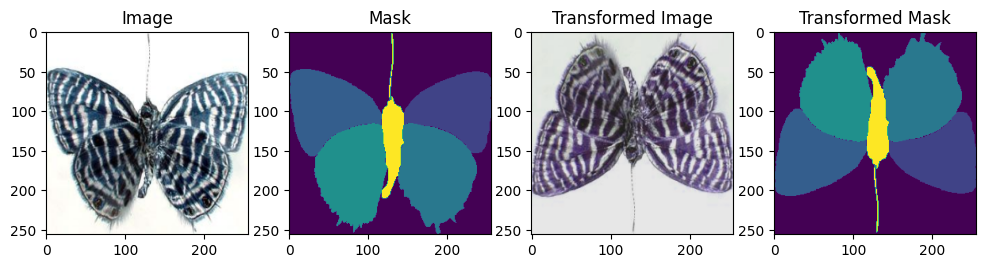

In [249]:
ex_image = train_images[0]
ex_mask = train_masks[0]

transformed = transform(image=ex_image, mask=ex_mask)

t_image=transformed['image']
t_mask=transformed['mask']

plt.figure(figsize=(12, 8))

plt.subplot(241)
plt.title('Image')
plt.imshow(ex_image);

plt.subplot(242)
plt.title('Mask')
plt.imshow(ex_mask);

plt.subplot(243)
plt.title('Transformed Image')
plt.imshow(t_image);

plt.subplot(244)
plt.title('Transformed Mask')
plt.imshow(t_mask);

In [403]:
aug_train_images = []
aug_train_masks = []

for orig_image, orig_mask in zip(train_images, train_masks):
  transformed = transform(image=orig_image, mask=orig_mask)
  aug_train_images.append(transformed['image'])
  aug_train_masks.append(transformed['mask'])

aug_train_images = np.array(aug_train_images)
aug_train_masks = np.array(aug_train_masks)

In [404]:
print(aug_train_images.shape)
print(aug_train_masks.shape)
np.unique(aug_train_masks)

(800, 256, 256)
(800, 256, 256)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

## Creating Train and Test Splits

In [405]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

## comment this line out if the train images are in color
if GRAY_SCALE:
  aug_train_images = np.expand_dims(aug_train_images, axis=3)
aug_train_masks_input = np.expand_dims(aug_train_masks, axis=3)

aug_train_images = normalize(aug_train_images, axis=1)

#Create a subset of data for quick testing - Picking 10% for testing and remaining for training
X1, X_test, y1, y_test = train_test_split(aug_train_images, aug_train_masks_input, test_size = 0.10, random_state = 0)

#Get train and val sets
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size = 0.10, random_state = 0)

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [406]:
X_train.shape

(648, 256, 256, 1)

In [407]:
X_train.shape

(648, 256, 256, 1)

## Class Weights

In [408]:
## Class weight balancing - automatic method using sklearn
# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils import class_weight

# labelencoder = LabelEncoder()
# n, h, w = train_masks.shape
# train_masks_reshaped = train_masks.reshape(-1,1)
# train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
# # np.unique(train_masks_reshaped_encoded)

# class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_masks_reshaped_encoded), y = train_masks_reshaped_encoded)
# class_weights = dict(zip(np.unique(train_masks_reshaped_encoded), class_weights))

## OR we can just set class weights manually
## Here, we're just increasing weights for wing categories 2,3,4,5
class_weights = dict()
class_weights[0] = 1.
class_weights[1] = 1.
class_weights[2] = 3.
class_weights[3] = 3.
class_weights[4] = 3.
class_weights[5] = 3.
class_weights[6] = 1.
class_weights[7] = 1.
class_weights[8] = 1.
class_weights[9] = 1.
class_weights[10]= 1.

print("Class weights are...:")
class_weights

Class weights are...:


{0: 1.0,
 1: 1.0,
 2: 3.0,
 3: 3.0,
 4: 3.0,
 5: 3.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0}

In [409]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

# 648 + 72 + 80 = 800

(648, 256, 256, 1)
(72, 256, 256, 1)
(80, 256, 256, 1)


## Train and Save U-Net Segmentation Model

In [411]:
print(MODEL_SAVE_PATH)

/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_corrected_orientation_data_augmentation_class_weights_cat_cross_entropy_loss_grayscale.hdf5


In [412]:
# Train Model
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_focal_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights.
#model.load_weights('???.hdf5')

num_epochs = 75
history = model.fit(X_train, y_train_cat,
                    batch_size = 16,
                    verbose=1,
                    epochs=num_epochs,
                    validation_data=(X_val, y_val_cat),
                    class_weight=class_weights,
                    shuffle=False)

model_save_path = MODEL_SAVE_PATH
model.save(model_save_path)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_247 (Conv2D)         (None, 256, 256, 16)         160       ['input_14[0][0]']            
                                                                                                  
 dropout_117 (Dropout)       (None, 256, 256, 16)         0         ['conv2d_247[0][0]']          
                                                                                                  
 conv2d_248 (Conv2D)         (None, 256, 256, 16)         2320      ['dropout_117[0][0]']         
                                                                                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load in Trained UNet Model (optional)

In [ ]:
# Load in trained model
model_save_path = MODEL_SAVE_PATH
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights(model_save_path)

## Evaluate the Model - Accuracy

In [413]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%") #accuracy drops with damaged classes

3/3 [==============================] - 0s 28ms/step - loss: 0.0932 - accuracy: 0.9826
Accuracy is =  98.26126098632812 %


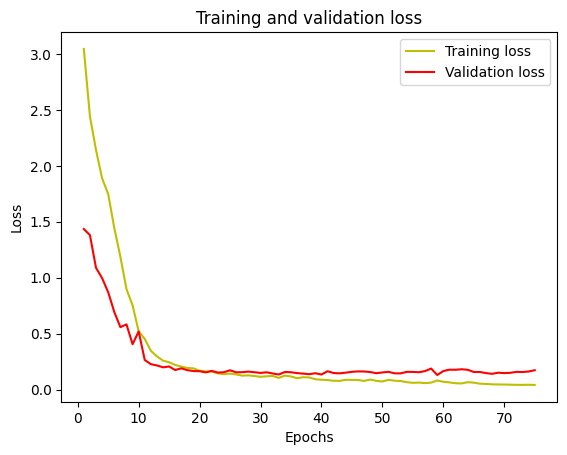

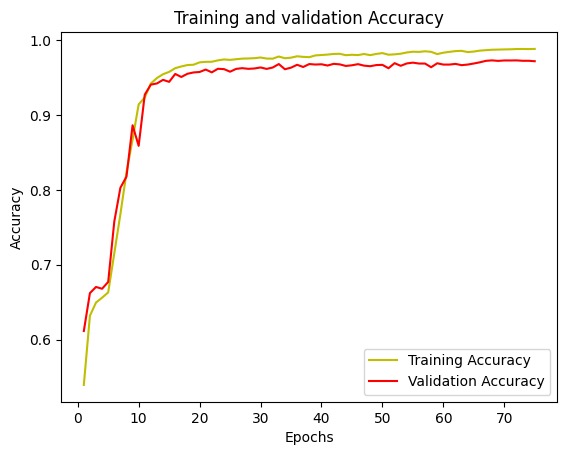

In [414]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate the Model (IOU)

In [415]:
#Evaluate the model: Intersection Over Union (IOU)
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

3/3 [==============================] - 0s 22ms/step


In [416]:
# Using built in keras function
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# plt.imshow(train_images[0, :,:,0], cmap='gray')
# plt.imshow(train_masks[0], cmap='gray')

Mean IoU = 0.84847087


In [417]:
#To calculate I0U for each class, divide each diag square in our values matrix by the sum of its row and col entries
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

class_iou = dict()
for i in range(0, values.shape[0]):
  diag_square = values[i,i]
  row_sum = np.sum(values[i, :])
  col_sum = np.sum(values[:, i]) - diag_square #subtract diag square bc it will already be include in row_sum

  iou = diag_square/(row_sum + col_sum)
  class_iou[i] = iou

print('CLASS IOUs:')
class_iou

CLASS IOUs:


{0: 0.98385787,
 1: 0.0,
 2: 0.95434165,
 3: 0.9526639,
 4: 0.92183614,
 5: 0.9180886,
 6: 0.93343896,
 7: 0.9856913,
 8: 0.932629,
 9: 0.9583849,
 10: 0.7922468}

## Visualize Predicted Masks on a Few Images

1/1 [==============================] - 0s 20ms/step


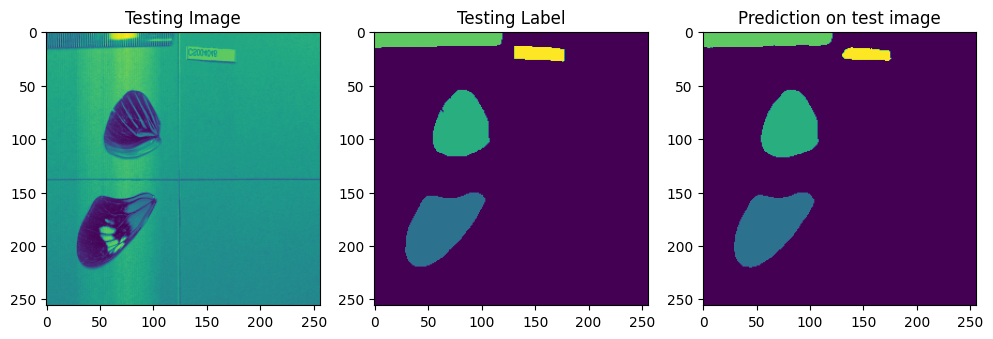

Test Image Number:  59
Classes Present in Predicted Mask:

background
left_forewing
left_hindwing
ruler
label


In [418]:
#Show prediction results on a few images
import random

id2label = {
0: 'background',
1: 'generic',
2: 'right_forewing',
3: 'left_forewing',
4: 'right_hindwing',
5: 'left_hindwing',
6: 'ruler',
7: 'white_balance',
8: 'label',
9: 'color_card',
10: 'body'}

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]

ground_truth=y_test[test_img_number]

## gray scale prediction
# test_img_norm=test_img[:,:,0][:,:,None]
# test_img_input=np.expand_dims(test_img_norm, 0)
# prediction = (model.predict(test_img_input))

## color prediction
test_img_input=np.expand_dims(test_img, axis=0)
prediction = (model.predict(test_img_input))

predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
# plt.imshow(test_img)

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

print('Test Image Number: ', test_img_number)
print('Classes Present in Predicted Mask:\n')
for i in np.unique(predicted_img):
  print(id2label[i])

In [131]:
print(test_img_number)
np.unique(predicted_img) #predicted classes

77


array([0, 2, 3, 4, 6, 8, 9])

In [134]:
id2label = {
0: 'background',
1: 'generic',
2: 'right_forewing',
3: 'left_forewing',
4: 'right_hindwing',
5: 'left_hindwing',
6: 'ruler',
7: 'white_balance',
8: 'label',
9: 'color_card',
10: 'body'}

## Change y and x to see what the pixel at this coordinate is classified as
y = 200 #vertical axis
x = 50 #horizontal axis

print('Testing label')
print(f'pixel value:           {ground_truth[:,:,0][y, x]}')
print(f'category   :           {id2label[ground_truth[:,:,0][y,x]]}')

print('\nPredicted label')
print(f'pixel value:           {predicted_img[y, x]}')
print(f'category   :           {id2label[predicted_img[y,x]]}')

Testing label
pixel value:           2
category   :           right_forewing_good

Predicted label
pixel value:           2
category   :           right_forewing_good
